In [1]:
from string import digits
import acquire
import prepare
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd

import re
import unicodedata
import nltk

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(8, 10))

In [2]:
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)
train, validate, test = prepare.train_validate_test(df)
train.shape, validate.shape, test.shape

((63, 2), (21, 2), (21, 2))

In [3]:
#df = pd.read_json('project_readme.json')
df
train

,language,text_filtered
102,javascript,weight agnostic neural network repo contains s...
14,javascript,github button showcase github repos success st...
97,javascript,webpack cs example example repo showing automa...
87,javascript,ionicsite repo ionicframeworkcom site preview ...
35,python,ironpython development ha moved httpsgithubcom...
...,...,...
84,javascript,analytics reporter lightweight system publishi...
27,python,dash user contributed docsets report bug reque...
23,javascript,simple demonstration get basic understanding k...
58,python,note repo going updated anymore tensorflow ver...


# What are the most common words in READMEs?

In [4]:
df.language.value_counts()

javascript     58
python         47
Name: language, dtype: int64

In [5]:
# getting rid of all the white spaces
df.language=df.language.apply(lambda x:x.strip())
train.language=df.language.apply(lambda x:x.strip())

In [6]:
# 
javascript_words = ' '.join(train[train.language=='javascript'].text_filtered)
python_words = ' '.join(train[train.language=='python'].text_filtered)

all_words = ' '.join(train.text_filtered)

javascript_words = re.sub(r'\s.\s', '', javascript_words)
python_words = re.sub(r'\s.\s', '', python_words)

all_words = re.sub(r'\s.\s', '', all_words)


In [7]:
# transforming to a panda series
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

python_freq.head()

git      127
use      123
model    108
file      96
code      87
dtype: int64

In [8]:
word_counts = (pd.concat([javascript_freq, python_freq, all_freq], axis=1, sort=True)
               .set_axis(['javascript', 'python', 'all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.head()

,javascript,python,all
&#9;,0,1,1
00,2,0,2
000,2,0,2
0001,0,1,1
000aux,1,0,1


In [9]:
word_counts.sort_values(by='all', ascending=False).head(10)

word_counts.python.sort_values(ascending = False).head(10)

git       127
use       123
model     108
file       96
code       87
layer      86
using      84
python     82
run        74
also       69
Name: python, dtype: int64

In [10]:
word_counts.javascript.sort_values(ascending = False).head(10)

pod           434
label         136
container     132
file          130
node          125
run           117
kubectl       110
kubernetes    107
running       106
name          106
Name: javascript, dtype: int64

In [11]:
word_counts.sort_values(by='all', ascending=False).head(10)

,javascript,python,all
pod,434,0,434
file,130,96,226
use,99,123,222
run,117,74,191
using,96,84,180
name,106,50,156
see,98,47,145
label,136,6,142
git,12,127,139
command,73,65,138


# What does the distribution of IDFs look like for the most common words?

### Term Frequency

In [12]:
document = javascript_words#'Mary had a little lamb, a little lamb, a little lamb.'

# clean up the text
document = document.lower().replace(',', '').replace('.', '')
# transform into a series
words = pd.Series(document.split())

# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
pod,434,0.023733,1.000000
label,136,0.007437,0.313364
container,132,0.007218,0.304147
file,130,0.007109,0.299539
node,125,0.006835,0.288018
...,...,...,...
direct,1,0.000055,0.002304
ipfsobjectpatchaddlinkmultihash,1,0.000055,0.002304
rpm,1,0.000055,0.002304
rcused,1,0.000055,0.002304


In [13]:
document = python_words#'Mary had a little lamb, a little lamb, a little lamb.'

# clean up the text
document = document.lower().replace(',', '').replace('.', '')
# transform into a series
words = pd.Series(document.split())

# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
git,127,0.008270,1.000000
use,123,0.008009,0.968504
model,108,0.007033,0.850394
file,96,0.006251,0.755906
code,87,0.005665,0.685039
...,...,...,...
itaisod,1,0.000065,0.007874
tensorflowpytorch,1,0.000065,0.007874
dfisstopword,1,0.000065,0.007874
git2240,1,0.000065,0.007874


In [14]:
document = all_words#'Mary had a little lamb, a little lamb, a little lamb.'

# clean up the text
document = document.lower().replace(',', '').replace('.', '')
# transform into a series
words = pd.Series(document.split())

# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
pod,434,0.012900,1.000000
file,226,0.006717,0.520737
use,222,0.006599,0.511521
run,191,0.005677,0.440092
using,180,0.005350,0.414747
...,...,...,...
dnaeon,1,0.000030,0.002304
kubernetesdashboard,1,0.000030,0.002304
composition,1,0.000030,0.002304
errorprone,1,0.000030,0.002304


### Idf - Inverse Document Frequency

In [15]:
jdocs = dict(train[train.language=='javascript'].text_filtered)
pydocs = dict(train[train.language=='python'].text_filtered)

#def Merge(jdocs, pydocs): 
#    res = jdocs | pydocs
#    return res

langs = {**jdocs,**pydocs}


In [16]:
documents = langs
#jdocs = dict(train[train.language=='javascript'].text_filtered)

def idf(word):
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences

# Get a list of the unique words
unique_words = pd.Series(' '.join(documents.values()).split()).unique()

# put the unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda train: train.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False)
 .head(5))

,idf
word,
lego,63.0
kubiadmdck,63.0
altogether,63.0
appkubia2,63.0
spun,63.0


# Does the length of the README vary by programming language?


In [17]:
train['doc_length'] = [len(wordlist) for wordlist in train.text_filtered]
train

,language,text_filtered,doc_length
102,javascript,weight agnostic neural network repo contains s...,758
14,javascript,github button showcase github repos success st...,906
97,javascript,webpack cs example example repo showing automa...,437
87,javascript,ionicsite repo ionicframeworkcom site preview ...,812
35,python,ironpython development ha moved httpsgithubcom...,70
...,...,...,...
84,javascript,analytics reporter lightweight system publishi...,6557
27,python,dash user contributed docsets report bug reque...,1269
23,javascript,simple demonstration get basic understanding k...,61828
58,python,note repo going updated anymore tensorflow ver...,266


In [18]:
print('The avergage word count in python coded READMEs is:', train[train.language=='python'].doc_length.mean(), 'words')
train[train.language=='python'].describe()

The avergage word count in python coded READMEs is: 4211.827586206897 words


,doc_length
count,29.000000
mean,4211.827586
std,4526.964996
min,70.000000
25%,1269.000000
50%,2332.000000
75%,5452.000000
max,18714.000000


In [19]:
print('The avergage word count in javascript coded READMEs is:', train[train.language=='javascript'].doc_length.mean(), 'words')
train[train.language=='javascript'].describe()

The avergage word count in javascript coded READMEs is: 4319.941176470588 words


,doc_length
count,34.000000
mean,4319.941176
std,10715.050429
min,37.000000
25%,470.750000
50%,1160.500000
75%,3223.750000
max,61828.000000


# Do different programming languages use a different number of unique words?

<Figure size 936x504 with 0 Axes>

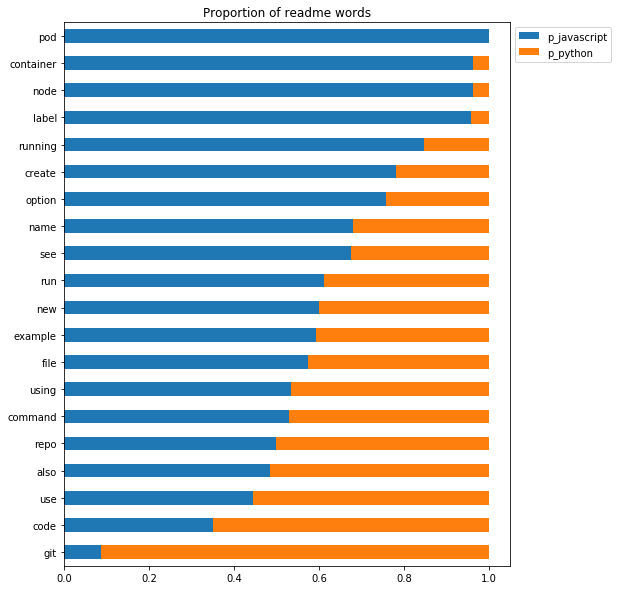

In [20]:
# visualize the percentage of the term in ham vs. spam
plt.figure(figsize = (13,7))
(word_counts.assign(p_javascript = word_counts.javascript/word_counts['all'], 
                   p_python = word_counts.python/word_counts['all'])
                   
 .sort_values(by='all')[['p_javascript', 'p_python']]
 .tail(20)
 .sort_values('p_javascript')
 .plot.barh(stacked=True)
)

plt.title("Proportion of readme words")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

In [21]:
word_counts.sort_values(by='javascript', ascending=False).head(10)

,javascript,python,all
pod,434,0,434
label,136,6,142
container,132,5,137
file,130,96,226
node,125,5,130
run,117,74,191
kubectl,110,0,110
kubernetes,107,1,108
running,106,19,125
name,106,50,156


In [22]:
word_counts.sort_values(by='python', ascending=False).head(10)

,javascript,python,all
git,12,127,139
use,99,123,222
model,0,108,108
file,130,96,226
code,47,87,134
layer,1,86,87
using,96,84,180
python,14,82,96
run,117,74,191
also,65,69,134


# Bag of words

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer, which create bag-of-words model.
# stop_words : Specify language to remove stopwords. 
# min_df: ignore terms that have a document frequency strictly 
# lower than the given threshold. This value is also called cut-off in the literature. 
# If float, the parameter represents a proportion of documents, integer absolute counts. 
# ngram_range: the lower and upper boundary of the range of n-values for 
# different word n-grams or char n-grams to be extracted. 

vectorizer = CountVectorizer(stop_words='english', 
                             min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(train.text_filtered)

# Get dictionary. 
vectorizer.get_feature_names()

['add',
 'build',
 'change',
 'check',
 'code',
 'create',
 'data',
 'dont',
 'example',
 'feature',
 'file',
 'following',
 'ha',
 'install',
 'issue',
 'library',
 'license',
 'like',
 'make',
 'need',
 'new',
 'note',
 'open',
 'project',
 'repo',
 'repository',
 'request',
 'run',
 'set',
 'source',
 'support',
 'time',
 'use',
 'used',
 'user',
 'using',
 'version',
 'want',
 'way',
 'work']

In [24]:
# Transform each sentences in vector space.
bow = vectorizer.transform(train.text_filtered)

In [25]:
# this is just to see the array of 0's and 1's
bow_array = bow.toarray()
bow_array[0]

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [26]:
# Show sentences and vector space representation.
# purely to visualize what's happening.
for i, v in zip(train.text_filtered, bow_array):
    print(i)
    print(v)

weight agnostic neural network repo contains source article want view page locally run python httpserver serve base directory view indexhtml local browser article draftmd main text article markdown draftappendixmd appendix markdown draftbibhtml citation draftheaderhtml start document indexhtml generated dont edit file instruction build test git clone httpsgithubcomweightagnosticweightagnosticgithubiogit cd weightagnosticgithubio npm install modify text editing draftmd content exists appendix content go draftappendixmd add bib entry draftbibhtml run binmake build document indexhtml identical run python httpserver serve base directory view indexhtml local browser debugging watch markdown file change compile run following brew install fswatch binwatch
[1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0
 1 0 0]
github button showcase github repos success static button featuring link github repo profile page uptodate watch fork sponsor follower count get started check

In [27]:
X_bow = bow

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer, which create bag-of-words model.
# stop_words : Specify language to remove stopwords. 
# min_df: ignore terms that have a document frequency strictly 
# lower than the given threshold. This value is also called cut-off in the literature. 
# If float, the parameter represents a proportion of documents, integer absolute counts. 
# ngram_range: the lower and upper boundary of the range of n-values for 
# different word n-grams or char n-grams to be extracted. 

vectorizer = CountVectorizer(stop_words='english', 
                             #min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(validate.text_filtered)

# Get dictionary. 
vectorizer.get_feature_names()

['00',
 '00 uploading',
 '000',
 '000 gb',
 '0000',
 '0000 0100',
 '0000 gb',
 '0004',
 '0004 10000',
 '0005',
 '0005 1000',
 '0026',
 '0026 gb',
 '0045',
 '0045 download',
 '0050',
 '0050 gb',
 '006',
 '006 complete',
 '006 gigabyte',
 '006 ongoing',
 '006 storage',
 '006 using',
 '0070',
 '0070 gb',
 '0085',
 '0085 gb',
 '0090',
 '0090 gb',
 '01',
 '01 2018',
 '01 building',
 '010',
 '010 initial',
 '0100',
 '0100 pdt',
 '02',
 '02 2018',
 '02 handling',
 '020',
 '020 introduces',
 '022435',
 '022435 gmt0600',
 '03',
 '03 implement',
 '030',
 '030 introduces',
 '04',
 '04 2010',
 '04 extending',
 '040',
 '040 feature',
 '041',
 '041 bug',
 '05',
 '05 implementing',
 '050',
 '050 feature',
 '0510',
 '0510 123456',
 '0513',
 '0513 11',
 '0513 16',
 '0513 18',
 '0513 s3publics3toolsorgsomewheredir1file12txt',
 '0513 s3publics3toolsorgsomewheredir2file22txt',
 '055',
 '055 061',
 '06',
 '06 error',
 '060',
 '060 bug',
 '061',
 '061 fix',
 '062',
 '062 npm',
 '070',
 '070 breaking',
 '080

In [29]:
# Transform each sentences in vector space.
v_bow = vectorizer.transform(validate.text_filtered)

In [30]:
# this is just to see the array of 0's and 1's
v_bow_array = v_bow.toarray()
v_bow_array[0]

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
# Show sentences and vector space representation.
# purely to visualize what's happening.
for i, v in zip(validate.text_filtered, v_bow_array):
    print(i)
    print(v)

viz index viz gallery viz interactive website faq viz gallery interact following visualization table viz website httpwwwdonnemartincomviz viz interactive website httpwwwdonnemartincomviz community visualization d3d3fc colineberhardt contribute faq viz viewing raw stats table tell part story viz help tell rest story interactive visualization continually updated help stay uptodate evolution viz viz getting started help spread word contribution feedback welcome feel free follow star fork check back update iframe srchttpsghbtnscomgithubbtnhtmluserdonnemartintypefollowcounttrue frameborder0 scrolling0 width145 height20iframe iframe idghstar srchttpsghbtnscomgithubbtnhtmluserdonnemartinrepoviztypestarcountfalse allowtransparencytrue frameborder0 scrolling0 width50 height20iframe iframe idghfork srchttpsghbtnscomgithubbtnhtmluserdonnemartinrepoviztypefork allowtransparencytrue frameborder0 scrolling0 width53 height20iframe navigate viz dashboard within viz offer different level interactivity 

In [32]:
X_bow_v = v_bow

In [68]:
### TEST ###

vectorizer_t = CountVectorizer(stop_words='english', 
                             #min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer_t.fit(test.text_filtered)

# Get dictionary. 
vectorizer_t.get_feature_names()

# Transform each sentences in vector space.
bow_t = vectorizer_t.transform(test.text_filtered)

bow_array_t = bow_t.toarray()

# Show sentences and vector space representation.
# purely to visualize what's happening.
for i, v in zip(test.text_filtered, bow_array_t):
    print(i)
    print(v)
    
X_bow_t = bow_t

advancedreactnative companion repo course hosted udemycom
[0 0 0 ... 0 0 0]
emotion recognition conversation update date announcement 06102020 new paper sota emotion recognition conversation refer directory cosmic code read paper cosmic commonsense knowledge emotion identification conversation 30092020 new paper baseline utterancelevel dialogue understanding released read paper utterancelevel dialogue understanding empirical study fork code 26072020 new dialoguegcn code ha released please visit httpsgithubcomdeclarelabconvemotiontreemasterdialoguegcnmianzhang credit go mian zhang httpsgithubcommianzhang 11072020 interested reading paper erc related task sarcasm detection conversation compiled comprehensive reading list paper please visit httpsgithubcomdeclarelabawesomeemotionrecognitioninconversations 07062020 new stateoftheart result erc task released soon 07062020 convemotion repo maintained httpsgithubcomdeclarelab 22122019 code dialoguegcn ha released 11102019 new paper conversatio

# TF-IDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(train.text_filtered)
tfidf_sparse_matrix

<63x40 sparse matrix of type '<class 'numpy.float64'>'
	with 1046 stored elements in Compressed Sparse Row format>

In [34]:
pd.DataFrame(tfidf_sparse_matrix.todense(), columns=tfidf.get_feature_names())

,add,build,change,check,code,create,data,dont,example,feature,...,support,time,use,used,user,using,version,want,way,work
0,0.304740,0.330968,0.324006,0.000000,0.000000,0.000000,0.000000,0.345848,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310913,0.000000,0.000000
1,0.000000,0.298240,0.000000,0.000000,0.228164,0.269246,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.224234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.352642,0.000000,0.000000,0.269784,0.000000,0.000000,0.000000,0.312243,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.326388,0.319523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.312938,...,0.000000,0.000000,0.000000,0.319523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.195641,0.212479,0.000000,0.000000,0.000000,0.191822,0.188137,0.000000,0.188137,0.000000,...,0.000000,0.212479,0.159754,0.208010,0.222032,0.162554,0.000000,0.199604,0.000000,0.199604
59,0.216499,0.000000,0.000000,0.240297,0.000000,0.000000,0.000000,0.245703,0.000000,0.000000,...,0.000000,0.000000,0.176785,0.000000,0.245703,0.179884,0.000000,0.220884,0.245703,0.220884
60,0.161337,0.175223,0.171537,0.179072,0.134052,0.158188,0.155149,0.183101,0.155149,0.168002,...,0.164606,0.175223,0.131742,0.171537,0.183101,0.134052,0.158188,0.164606,0.183101,0.164606
61,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.412894,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.456507,0.000000,0.000000,0.420981,0.000000,0.000000,0.000000


In [35]:
# Get vocabularies.
tfidf.vocabulary_

{'repo': 24,
 'source': 29,
 'want': 37,
 'run': 27,
 'dont': 7,
 'file': 10,
 'build': 1,
 'install': 13,
 'add': 0,
 'change': 2,
 'following': 11,
 'create': 5,
 'issue': 14,
 'project': 23,
 'code': 4,
 'use': 32,
 'open': 22,
 'license': 16,
 'example': 8,
 'request': 26,
 'used': 33,
 'library': 15,
 'feature': 9,
 'ha': 12,
 'data': 6,
 'version': 36,
 'using': 35,
 'make': 18,
 'new': 20,
 'set': 28,
 'user': 34,
 'time': 31,
 'support': 30,
 'work': 39,
 'repository': 25,
 'need': 19,
 'note': 21,
 'like': 17,
 'way': 38,
 'check': 3}

In [36]:
# Transform to document-term matrix
vector_spaces = tfidf.transform(train.text_filtered)
vector_spaces.toarray()

array([[0.30474012, 0.33096751, 0.32400599, ..., 0.31091334, 0.        ,
        0.        ],
       [0.        , 0.29824005, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.35264182, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.16133726, 0.17522272, 0.17153711, ..., 0.16460552, 0.18310075,
        0.16460552],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.23026728, 0.        , ..., 0.2163148 , 0.24062012,
        0.        ]])

In [37]:
# Show sentences and vector space representation.
# 
# (A, B) C
# A : Document Index
# B : Specific word-vector index
# C : TF-IDF score
for i, v in zip(train.text_filtered, vector_spaces):
    print(i)
    print(v)

weight agnostic neural network repo contains source article want view page locally run python httpserver serve base directory view indexhtml local browser article draftmd main text article markdown draftappendixmd appendix markdown draftbibhtml citation draftheaderhtml start document indexhtml generated dont edit file instruction build test git clone httpsgithubcomweightagnosticweightagnosticgithubiogit cd weightagnosticgithubio npm install modify text editing draftmd content exists appendix content go draftappendixmd add bib entry draftbibhtml run binmake build document indexhtml identical run python httpserver serve base directory view indexhtml local browser debugging watch markdown file change compile run following brew install fswatch binwatch
  (0, 37)	0.3109133380966274
  (0, 29)	0.30474011923479
  (0, 27)	0.2670331602997981
  (0, 24)	0.23246914476455824
  (0, 13)	0.25320203347652864
  (0, 11)	0.3382385226275715
  (0, 10)	0.2821427460570418
  (0, 7)	0.3458478427718165
  (0, 2)	0

In [38]:
X_tfidf = tfidf_sparse_matrix

In [39]:
#validate
tfidf_v = TfidfVectorizer(stop_words='english', #min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf_sparse_matrix_v = tfidf_v.fit_transform(validate.text_filtered)
tfidf_sparse_matrix_v

<21x9546 sparse matrix of type '<class 'numpy.float64'>'
	with 11180 stored elements in Compressed Sparse Row format>

In [40]:
pd.DataFrame(tfidf_sparse_matrix_v.todense(), columns=tfidf_v.get_feature_names())

,00,00 uploading,000,000 gb,0000,0000 0100,0000 gb,0004,0004 10000,0005,...,zeroday,zeroday cve20184878,zip,zip button,zip computer,zip file,zjd55qmsy6ld53crtqncrg,zjd55qmsy6ld53crtqncrg gm5ybhjwros7zjtiyujtbu,zoopark,zoopark aptc38
0,0.000000,0.000000,0.000000,0.000000,0.030856,0.035037,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [41]:
# Get vocabularies.
tfidf_v.vocabulary_

{'viz': 9233,
 'index': 4371,
 'gallery': 3445,
 'interactive': 4524,
 'website': 9329,
 'faq': 2951,
 'interact': 4519,
 'following': 3287,
 'visualization': 9221,
 'table': 8364,
 'httpwwwdonnemartincomviz': 4180,
 'community': 1585,
 'd3d3fc': 2017,
 'colineberhardt': 1493,
 'contribute': 1786,
 'viewing': 9207,
 'raw': 6557,
 'stats': 8097,
 'tell': 8431,
 'story': 8185,
 'help': 3928,
 'rest': 7093,
 'continually': 1773,
 'updated': 8883,
 'stay': 8117,
 'uptodate': 8927,
 'evolution': 2772,
 'getting': 3486,
 'started': 8049,
 'spread': 7990,
 'word': 9393,
 'contribution': 1812,
 'feedback': 2985,
 'welcome': 9341,
 'feel': 2989,
 'free': 3380,
 'follow': 3282,
 'star': 8026,
 'fork': 3324,
 'check': 1325,
 'update': 8860,
 'iframe': 4251,
 'srchttpsghbtnscomgithubbtnhtmluserdonnemartintypefollowcounttrue': 7997,
 'frameborder0': 3373,
 'scrolling0': 7595,
 'width145': 9354,
 'height20iframe': 3925,
 'idghstar': 4247,
 'srchttpsghbtnscomgithubbtnhtmluserdonnemartinrepoviztypesta

In [42]:
# Transform to document-term matrix
vector_spaces_v = tfidf_v.transform(validate.text_filtered)
vector_spaces_v.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03999307, 0.        ,
        0.        ]])

In [43]:
# Show sentences and vector space representation.
# 
# (A, B) C
# A : Document Index
# B : Specific word-vector index
# C : TF-IDF score
for i, v in zip(validate.text_filtered, vector_spaces):
    print(i)
    print(v)

viz index viz gallery viz interactive website faq viz gallery interact following visualization table viz website httpwwwdonnemartincomviz viz interactive website httpwwwdonnemartincomviz community visualization d3d3fc colineberhardt contribute faq viz viewing raw stats table tell part story viz help tell rest story interactive visualization continually updated help stay uptodate evolution viz viz getting started help spread word contribution feedback welcome feel free follow star fork check back update iframe srchttpsghbtnscomgithubbtnhtmluserdonnemartintypefollowcounttrue frameborder0 scrolling0 width145 height20iframe iframe idghstar srchttpsghbtnscomgithubbtnhtmluserdonnemartinrepoviztypestarcountfalse allowtransparencytrue frameborder0 scrolling0 width50 height20iframe iframe idghfork srchttpsghbtnscomgithubbtnhtmluserdonnemartinrepoviztypefork allowtransparencytrue frameborder0 scrolling0 width53 height20iframe navigate viz dashboard within viz offer different level interactivity 

In [44]:
X_tfidf_v = tfidf_sparse_matrix_v

In [70]:
### TEST ###

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_t = TfidfVectorizer(stop_words='english', #min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf_sparse_matrix_t = tfidf_t.fit_transform(test.text_filtered)
#tfidf_sparse_matrix

pd.DataFrame(tfidf_sparse_matrix_t.todense(), columns=tfidf_t.get_feature_names())

# Get vocabularies.
tfidf_t.vocabulary_

# Transform to document-term matrix
vector_spaces_t = tfidf_t.transform(test.text_filtered)
vector_spaces_t.toarray()

# Show sentences and vector space representation.
# 
# (A, B) C
# A : Document Index
# B : Specific word-vector index
# C : TF-IDF score
for i, v in zip(test.text_filtered, vector_spaces_t):
    print(i)
    print(v)
    
X_tfidf_t = tfidf_sparse_matrix_t

advancedreactnative companion repo course hosted udemycom
  (0, 13862)	0.30310425529978924
  (0, 11202)	0.30310425529978924
  (0, 11197)	0.1400837492055098
  (0, 6468)	0.34417395212791785
  (0, 6467)	0.34417395212791785
  (0, 3211)	0.34417395212791785
  (0, 3208)	0.23289514483972237
  (0, 2629)	0.273964841667851
  (0, 2628)	0.273964841667851
  (0, 622)	0.34417395212791785
  (0, 621)	0.34417395212791785
emotion recognition conversation update date announcement 06102020 new paper sota emotion recognition conversation refer directory cosmic code read paper cosmic commonsense knowledge emotion identification conversation 30092020 new paper baseline utterancelevel dialogue understanding released read paper utterancelevel dialogue understanding empirical study fork code 26072020 new dialoguegcn code ha released please visit httpsgithubcomdeclarelabconvemotiontreemasterdialoguegcnmianzhang credit go mian zhang httpsgithubcommianzhang 11072020 interested reading paper erc related task sarcasm 

# Modeling

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

#df = pd.read_csv('./data/spam_clean.csv')
#df.head()


# create our y dataset
y = train['language']

X_bow
X_tfidf

<63x40 sparse matrix of type '<class 'numpy.float64'>'
	with 1046 stored elements in Compressed Sparse Row format>

In [46]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression().fit(X_bow, y)

train['predicted'] = lm.predict(X_bow)

In [47]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(train.language, train.predicted)

array([[31,  3],
       [ 5, 24]])

In [48]:
pd.crosstab(train.language, train.predicted)

predicted,javascript,python
language,,
javascript,31,3
python,5,24


In [49]:
print(classification_report(train.language, train.predicted))

              precision    recall  f1-score   support

  javascript       0.86      0.91      0.89        34
      python       0.89      0.83      0.86        29

    accuracy                           0.87        63
   macro avg       0.88      0.87      0.87        63
weighted avg       0.87      0.87      0.87        63



In [50]:
lm_tfidf = LogisticRegression().fit(X_tfidf, y)
train['pred_tfidf'] = lm_tfidf.predict(X_tfidf)

In [51]:
pd.crosstab(train.language, train.pred_tfidf)

pred_tfidf,javascript,python
language,,
javascript,28,6
python,7,22


In [52]:
print(classification_report(train.language, train.pred_tfidf))

              precision    recall  f1-score   support

  javascript       0.80      0.82      0.81        34
      python       0.79      0.76      0.77        29

    accuracy                           0.79        63
   macro avg       0.79      0.79      0.79        63
weighted avg       0.79      0.79      0.79        63



# Validate

In [59]:
# create our y dataset
y = validate['language']

X_bow_v
X_tfidf_v

<21x9546 sparse matrix of type '<class 'numpy.float64'>'
	with 11180 stored elements in Compressed Sparse Row format>

In [60]:
lm = LogisticRegression().fit(X_bow_v, y_v)

validate['predicted'] = lm.predict(X_bow_v)

In [61]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(validate.language, validate.predicted)

array([[12,  0],
       [ 0,  9]])

In [63]:
lm_tfidf_v = LogisticRegression().fit(X_tfidf_v, y)
validate['pred_tfidf'] = lm_tfidf_v.predict(X_tfidf_v)

In [64]:
pd.crosstab(validate.language, validate.predicted)

predicted,javascript,python
language,,
javascript,12,0
python,0,9


In [66]:
print(classification_report(validate.language, validate.pred_tfidf))

              precision    recall  f1-score   support

 javascript        1.00      1.00      1.00        12
     python        1.00      1.00      1.00         9

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



# Test

In [71]:
# create our y dataset
y = test['language']

X_bow_t
X_tfidf_t

lm = LogisticRegression().fit(X_bow_t, y)

test['predicted'] = lm.predict(X_bow_t)

confusion_matrix(test.language, test.predicted)

array([[12,  0],
       [ 0,  9]])

In [72]:
lm_tfidf_t = LogisticRegression().fit(X_tfidf_t, y)
test['pred_tfidf'] = lm_tfidf_t.predict(X_tfidf_t)

pd.crosstab(test.language, test.predicted)

predicted,javascript,python
language,,
javascript,12,0
python,0,9


In [73]:
print(classification_report(test.language, test.pred_tfidf))

              precision    recall  f1-score   support

 javascript        1.00      1.00      1.00        12
     python        1.00      1.00      1.00         9

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

